In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from tqdm import trange, tqdm
import itertools
import logging

import sys
sys.path.append('../src')

from DeepGenerativeModels.NormalizingFlows import NormalizingFlowModel, Planar, Radial

/Users/Shulgin_Egor/miniconda3/envs/dl/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
def gen_data(n=512):
    return np.r_[np.random.randn(n // 3, 2) + np.array([0, 6]),
                 np.random.randn(n // 3, 2) + np.array([2.5, 3]),
                 np.random.randn(n // 3, 2) + np.array([-2.5, 3])]


def gen_mixture_data(n=512):
    return np.r_[np.random.randn(n // 2, 2) + np.array([5, 3]),
                 np.random.randn(n // 2, 2) + np.array([-5, 3])]


def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], marker="x", **kwargs)

In [196]:
class uniform_2d(sps.rv_continuous): 
    "uniform 2d distribution"
    def _pdf(self, x):
        return np.ones(len(x) // 2)
    def _cdf(self, x):
        return x[0] + x[1]
    def rvs(self, n):
        return sps.uniform().rvs((n, 2))

In [242]:
def plot_distr(distribution=None, n_samples=2000, scatter_plot=True, title=""):
    sample = distribution.rvs(n_samples)
    x, y = sample[:, 0], sample[:, 1]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(distribution.pdf(positions.T), X.shape)

    plt.figure(figsize=(8, 6))

    plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, # cmap="summer"
               extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    if scatter_plot:
        plt.plot(x, y, 'k.', markersize=2)
    plt.title(title)

    plt.show()

In [244]:
def flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), model=None,
                  flow_type="Planar", flow_depth=10, opt_max_iter=10**3, **kwargs):
    x = torch.Tensor(data)

    if model is None:
        flow = eval(flow_type)
        flows = [flow(dim=2) for _ in range(flow_depth)]

        model = NormalizingFlowModel(prior_distr, flows)

    optimizer = optim.Adam(model.parameters(), **kwargs)

    for i in trange(opt_max_iter):
        optimizer.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = - torch.mean(prior_logprob + log_det)
        loss.backward()
        optimizer.step()

        if i % (opt_max_iter // 5) == 0:
            logger.info(f"Iter: {i}\t" +
                        f"Logprob: {logprob.mean().data:.2f}\t" +
                        f"Prior: {prior_logprob.mean().data:.2f}\t" +
                        f"LogDet: {log_det.mean().data:.2f}")
    
    plot_data(model(x)[0].detach().numpy())
    plt.show()
    
    return model

# Planar Flows

**Data** $p(x) \sim U(0,1) \times U(0,1)$ (2-d Uniform distribution)  
**Prior** distribution $ p(z) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 0 \\ 0 \end{smallmatrix} \right], \left[ \begin{smallmatrix} 1 & 0 \\ 0 & 1 \end{smallmatrix} \right] \right)$   

In [240]:
n_data_samples = 1000
data_distr = uniform_2d()
data = data_distr.rvs(n_data_samples)

prior = sps.multivariate_normal(torch.zeros(2), torch.eye(2))

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


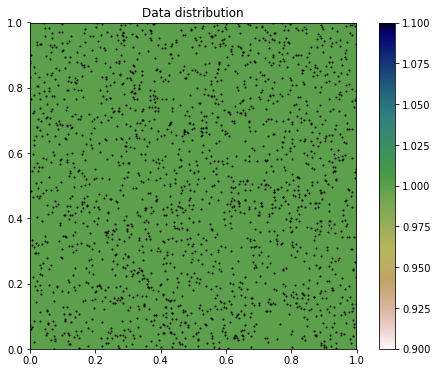

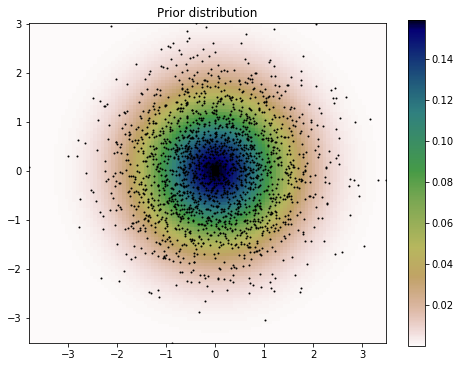

In [243]:
plot_distr(data_distr, title="Data distribution");
plot_distr(prior, title="Prior distribution")

In [254]:
flow_depth = 2

100%|██████████| 1000/1000 [00:04<00:00, 232.93it/s]


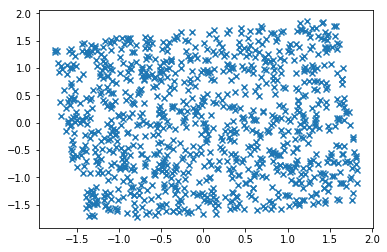

In [255]:
model = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                      flow_type='Planar', flow_depth=flow_depth, lr=0.01)

In [256]:
flow_depth = 10

100%|██████████| 1000/1000 [00:15<00:00, 63.85it/s]


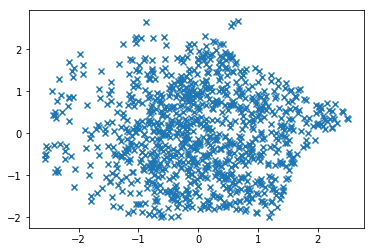

In [257]:
model_2 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Planar', flow_depth=flow_depth, lr=0.01)

**Data** $p(x) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 1 \\ 1 \end{smallmatrix} \right], \left[ \begin{smallmatrix} 2 & 2/3 \\ 2/3 & 7 \end{smallmatrix} \right] \right)$   
**Prior** distribution $ p(z) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 0 \\ 0 \end{smallmatrix} \right], \left[ \begin{smallmatrix} 1 & 0 \\ 0 & 1 \end{smallmatrix} \right] \right)$   

In [264]:
n_data_samples = 1000
data_distr = sps.multivariate_normal([1, 1], [[2, 2/3], 
                                              [2/3, 7]])
data = data_distr.rvs(n_data_samples)

prior = sps.multivariate_normal(torch.zeros(2), torch.eye(2))

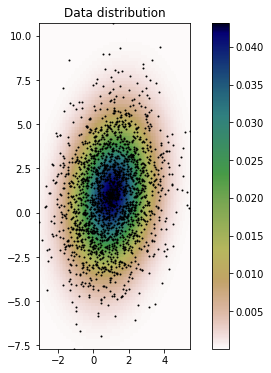

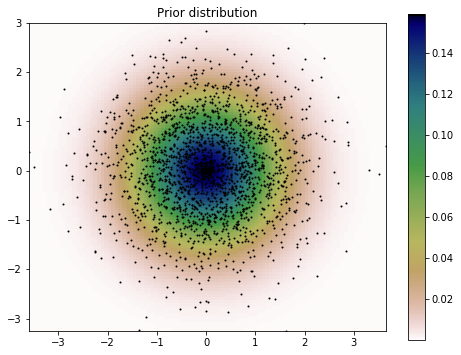

In [265]:
plot_distr(data_distr, title="Data distribution");
plot_distr(prior, title="Prior distribution")

In [266]:
flow_depth = 2

100%|██████████| 1000/1000 [00:04<00:00, 228.51it/s]


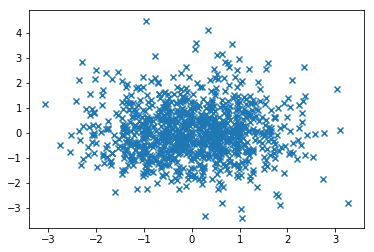

In [268]:
model = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                      flow_type='Planar', flow_depth=flow_depth, lr=0.01)

In [269]:
flow_depth = 10

100%|██████████| 1000/1000 [00:15<00:00, 64.84it/s]


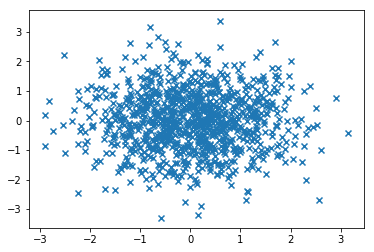

In [270]:
model_2 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Planar', flow_depth=flow_depth, lr=0.01)

More fancy data distribution

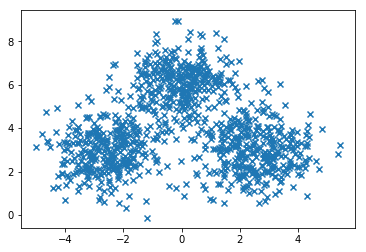

In [288]:
data = gen_data(n_data_samples)
plot_data(data);

In [289]:
flow_depth = 10

100%|██████████| 1000/1000 [00:15<00:00, 64.81it/s]


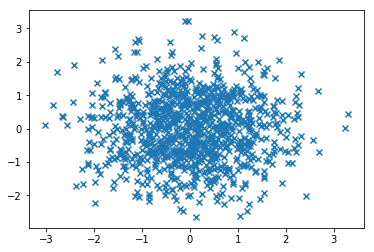

In [290]:
model_2 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Planar', flow_depth=flow_depth, lr=0.01)

# Radial Flows

**Data** $p(x) \sim U(0,1) \times U(0,1)$ (2-d Uniform distribution)  
**Prior** distribution $ p(z) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 0 \\ 0 \end{smallmatrix} \right], \left[ \begin{smallmatrix} 1 & 0 \\ 0 & 1 \end{smallmatrix} \right] \right)$   

In [271]:
n_data_samples = 1000
data_distr = uniform_2d()
data = data_distr.rvs(n_data_samples)

prior = sps.multivariate_normal(torch.zeros(2), torch.eye(2))

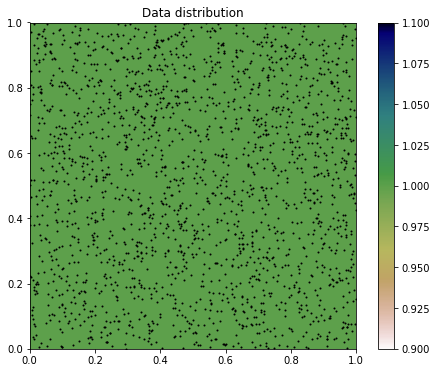

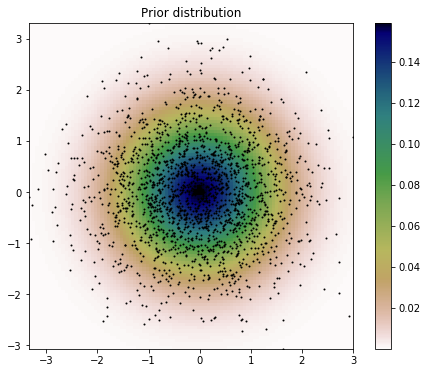

In [272]:
plot_distr(data_distr, title="Data distribution");
plot_distr(prior, title="Prior distribution")

In [273]:
flow_depth = 2

100%|██████████| 1000/1000 [00:02<00:00, 408.51it/s]


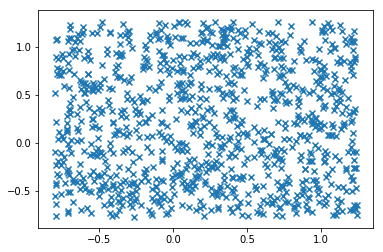

In [274]:
model = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                      flow_type='Radial', flow_depth=flow_depth, lr=0.01)

In [275]:
flow_depth = 10

100%|██████████| 1000/1000 [00:09<00:00, 110.26it/s]


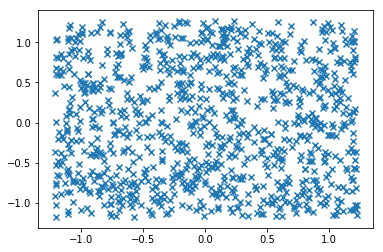

In [276]:
model_2 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Radial', flow_depth=flow_depth, lr=0.01)

**Data** $p(x) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 1 \\ 1 \end{smallmatrix} \right], 
                                \left[ \begin{smallmatrix} 2 & 2/3 \\ 2/3 & 7 \end{smallmatrix} \right] \right)$   
**Prior** distribution $ p(z) \sim \mathcal{N} \left(\left[ \begin{smallmatrix} 0 \\ 0 \end{smallmatrix} \right], \left[ \begin{smallmatrix} 1 & 0 \\ 0 & 1 \end{smallmatrix} \right] \right)$   

In [277]:
n_data_samples = 1000
data_distr = sps.multivariate_normal([1, 1], [[2, 2/3], 
                                              [2/3, 7]])
data = data_distr.rvs(1000)
prior = sps.multivariate_normal(torch.zeros(2), torch.eye(2))

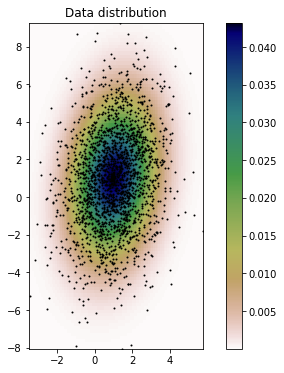

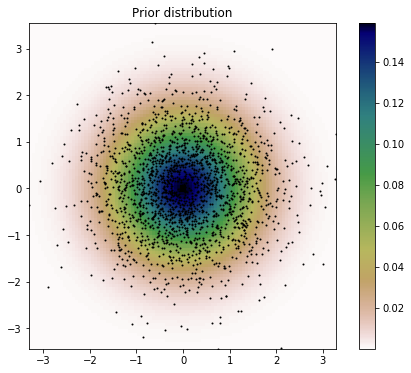

In [278]:
plot_distr(data_distr, title="Data distribution");
plot_distr(prior, title="Prior distribution")

In [266]:
flow_depth = 2

100%|██████████| 1000/1000 [00:14<00:00, 71.11it/s]


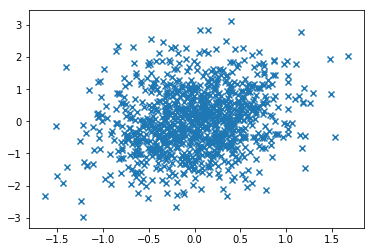

In [279]:
model = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                      flow_type='Radial', flow_depth=flow_depth, lr=0.01)

In [280]:
flow_depth = 10

100%|██████████| 1000/1000 [00:09<00:00, 110.00it/s]


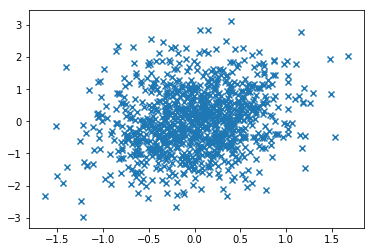

In [285]:
model_2 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Radial', flow_depth=flow_depth, lr=0.01)

More fancy data distribution

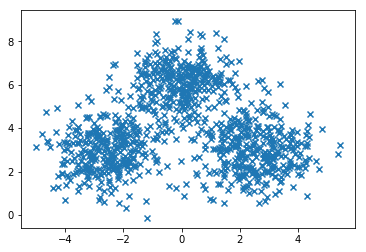

In [288]:
data = gen_data(n_data_samples)
plot_data(data);

In [292]:
flow_depth = 10

100%|██████████| 1000/1000 [00:09<00:00, 103.60it/s]


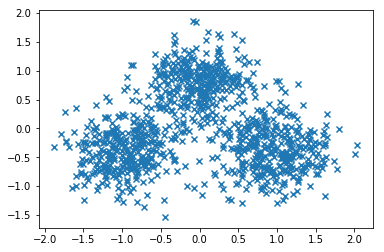

In [294]:
model_3 = flow_training(data, prior_distr=MultivariateNormal(torch.zeros(2), torch.eye(2)), 
                        flow_type='Radial', flow_depth=flow_depth, lr=0.01)

# Conclusion

According to work results on mixture of 3 gaussians (mentioned "fancy" distribution) I conclude that Planar Flows can generate a wider class of distributions.